In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive"
path="/content/drive/My Drive/image captioning/"

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = path+'Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [ ]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [ ]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
  #maketrans: arg1: list of char needs to be replced with list in arg2, arg3: list of char needs to be deleted
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [ ]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [ ]:
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, path+'descriptions.txt')

In [ ]:
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = path+'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [ ]:
images = path+'Flickr8k_Dataset/Flicker8k_Dataset/'
# Create a list of all image names in the directory
print(len(images))
img = glob.glob(images + '*.jpg')
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')
len(img)

76


8091

In [ ]:
# Below file conatains the names of images to be used in train data
train_images_file =path+'Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [ ]:
# Below file conatains the names of images to be used in test data
test_images_file = path+'Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [ ]:
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions(path+'descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [ ]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
print(len(img))
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

8091


In [ ]:
# # Call the funtion to encode all the train images
# # This will take a while on CPU - Execute this only once
# start = time()
# encoding_train = {}
# for img in train_img:
#     encoding_train[img[len(images):]] = encode(img)
# print("Time taken in seconds =", time()-start)

Time taken in seconds = 4030.097534418106


In [ ]:
# # Save the bottleneck train features to disk
# import pickle
# with open( path+'encoded_train_imagesnew1.pkl', 'wb') as encoded_pickle:
#    pickle.dump(encoding_train, encoded_pickle)
  

In [ ]:
# filename=path+'encoded_train_imagesnew1.pkl'
# print(filename)
# scores = {} # scores is an empty dict already

# if os.path.getsize(filename) > 0:      
#     with open(filename, "rb") as f:
#         unpickler = pickle.Unpickler(f)
#         # if file is not empty scores will be equal
#         # to the value unpickled
#         scores = unpickler.load()
# print(scores)
train_features = load(open(path+'encoded_train_imagesnew1.pkl', "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
# start = time()
# encoding_test = {}
# for img in test_img:
#     encoding_test[img[len(images):]] = encode(img)
# print("Time taken in seconds =", time()-start)

Time taken in seconds = 680.372775554657


In [ ]:
# # Save the bottleneck test features to disk
# with open(path+'encoded_test_images1.pkl', "wb") as encoded_pickle:
#     pickle.dump(encoding_test, encoded_pickle)

In [ ]:
test_features = load(open(path+'encoded_test_images1.pkl', "rb"))
print('Photos: train=%d' % len(test_features))

Photos: train=1000


In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
# Load Glove vectors
glove_dir = path+"glove6b200d/"
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1652, 200)

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [ ]:
model.layers[2]

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(path+'model1_' + str(i) + '.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
2000/2000 [==============================] - 928s 464ms/step - loss: 4.1264
Epoch 1/1
2000/2000 [==============================] - 924s 462ms/step - loss: 3.4228
Epoch 1/1
2000/2000 [==============================] - 920s 460ms/step - loss: 3.2056
Epoch 1/1
2000/2000 [==============================] - 915s 457ms/step - loss: 3.0718
Epoch 1/1
2000/2000 [==============================] - 927s 463ms/step - loss: 2.9760
Epoch 1/1
2000/2000 [==============================] - 930s 465ms/step - loss: 2.9043
Epoch 1/1
2000/2000 [==============================] - 926s 463ms/step - loss: 2.8476
Epoch 1/1
2000/2000 [==============================] - 927s 464ms/step - loss: 2.7993
Epoch 1/1
2000/2000 [==============================] - 924s 462ms/step - loss: 2.7606
Epoch 1/1
2000/2000 [==============================] - 926s 463ms/step - loss: 2.7279


In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(path+'model2_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 922s 461ms/step - loss: 2.6076
Epoch 1/1
2000/2000 [==============================] - 932s 466ms/step - loss: 2.5901
Epoch 1/1
2000/2000 [==============================] - 924s 462ms/step - loss: 2.5782
Epoch 1/1
2000/2000 [==============================] - 931s 465ms/step - loss: 2.5658
Epoch 1/1
2000/2000 [==============================] - 945s 473ms/step - loss: 2.5561
Epoch 1/1
2000/2000 [==============================] - 927s 463ms/step - loss: 2.5435
Epoch 1/1
2000/2000 [==============================] - 923s 461ms/step - loss: 2.5317
Epoch 1/1
2000/2000 [==============================] - 933s 466ms/step - loss: 2.5239
Epoch 1/1
2000/2000 [==============================] - 936s 468ms/step - loss: 2.5163
Epoch 1/1
2000/2000 [==============================] - 928s 464ms/step - loss: 2.5067


In [ ]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 790s 790ms/step - loss: 2.4662
Epoch 1/1
1000/1000 [==============================] - 807s 807ms/step - loss: 2.4480
Epoch 1/1
1000/1000 [==============================] - 800s 800ms/step - loss: 2.4375
Epoch 1/1
1000/1000 [==============================] - 803s 803ms/step - loss: 2.4282
Epoch 1/1
1000/1000 [==============================] - 799s 799ms/step - loss: 2.4225
Epoch 1/1
1000/1000 [==============================] - 803s 803ms/step - loss: 2.4113
Epoch 1/1
1000/1000 [==============================] - 798s 798ms/step - loss: 2.4024
Epoch 1/1
1000/1000 [==============================] - 806s 806ms/step - loss: 2.3985
Epoch 1/1
1000/1000 [==============================] - 797s 797ms/step - loss: 2.3886
Epoch 1/1
1000/1000 [==============================] - 798s 798ms/step - loss: 2.3830


In [ ]:
model.save_weights(path+'model_30.h5')

In [ ]:
# model.load_weights(path+'model2_9.h5')
model.load_weights(path+'model_30.h5')

In [ ]:
images =  path+'Flickr8k_Dataset/Flicker8k_Dataset/'

In [ ]:
with open(path+'encoded_test_images1.pkl', "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

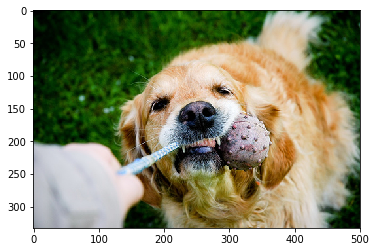

Greedy: dog is licking its fur nose


In [ ]:
z=35
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
  actual, predicted = list(), list()
  c=0
	# step over the whole set
  for key, desc_list in descriptions.items():
    
    # generate description
    #yhat = generate_desc(model, tokenizer, photos[key], max_length)
    pic = list(encoding_test.keys())[c]
    c=c+1
    image = encoding_test[pic].reshape((1,2048))
    yhat=greedySearch(image)
    # store actual and predicted
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [ ]:
# load test set
test_filename = path+'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(test_filename)
print('Dataset: %d' % len(test))

# descriptions
test_descriptions = load_clean_descriptions(path+'descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

# photo features
# test_features = load_photo_features('features.pkl', test)
# print('Photos: test=%d' % len(test_features))

test_features = load(open(path+'encoded_test_images1.pkl', "rb"))
print('Photos: test=%d' % len(test_features))

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)

# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.253693
BLEU-2: 0.104014
BLEU-3: 0.061357
BLEU-4: 0.019895
